Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_9 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 7, 7, 128)        

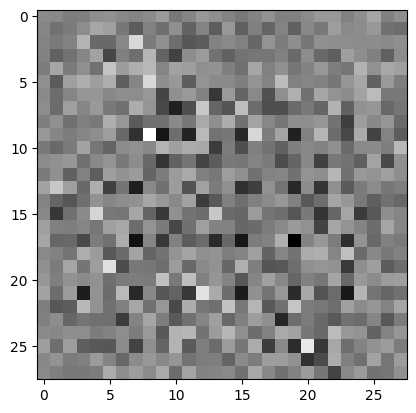

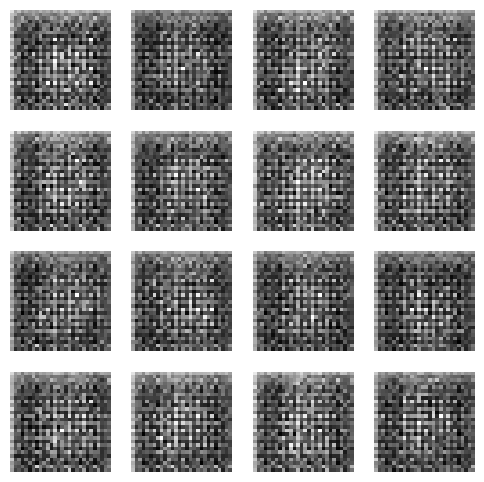

Epoch:  2


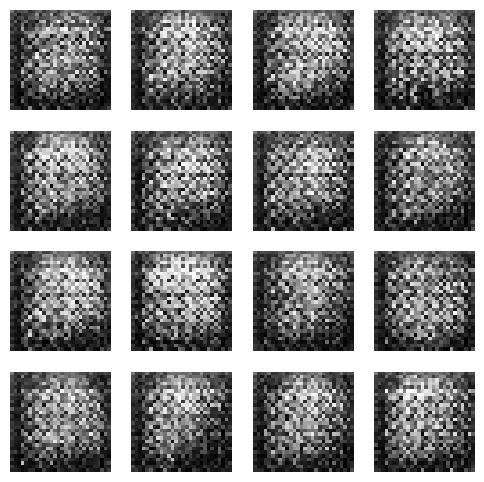

Epoch:  3


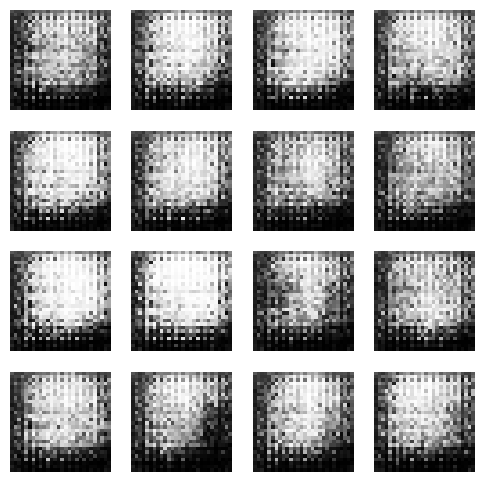

Epoch:  4


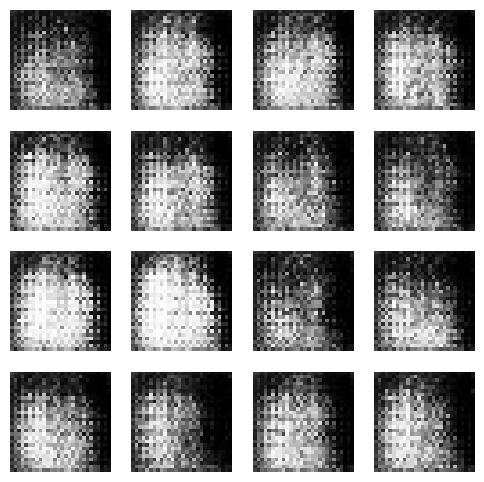

Epoch:  5


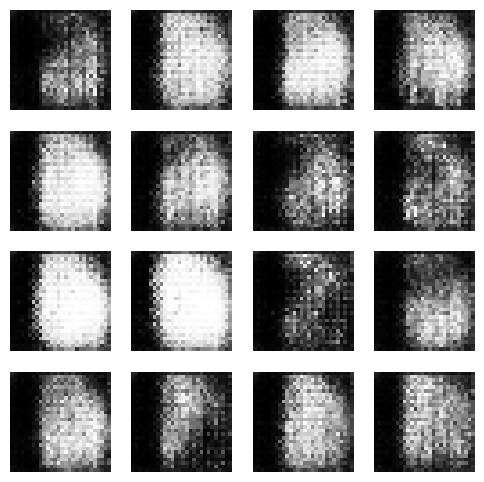

Epoch:  6


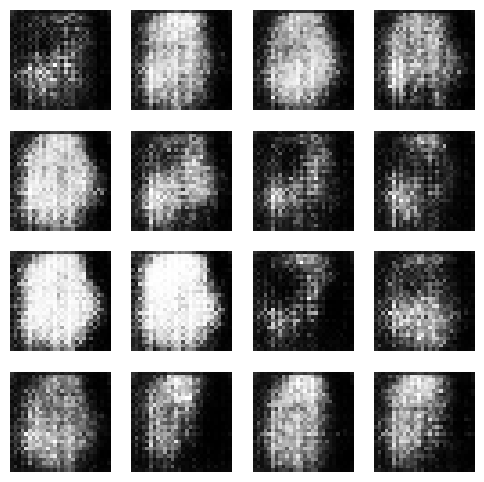

Epoch:  7


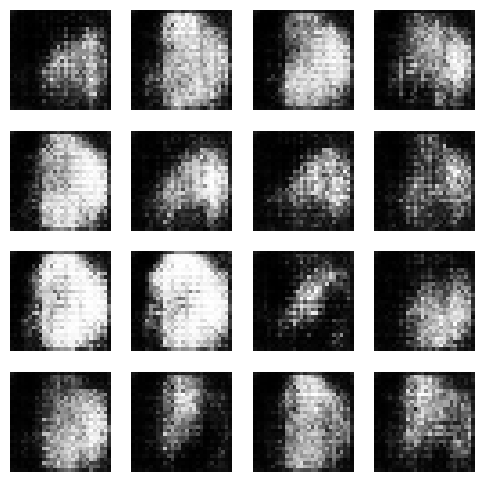

Epoch:  8


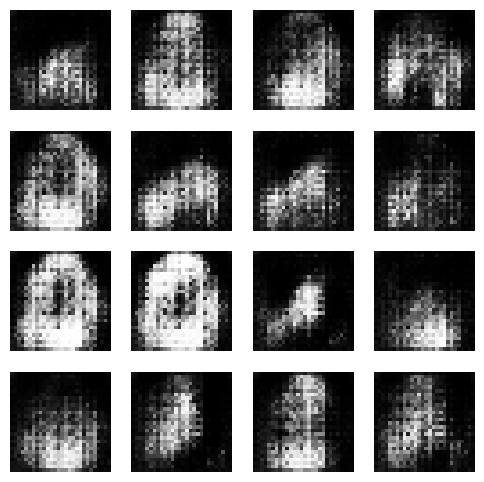

Epoch:  9


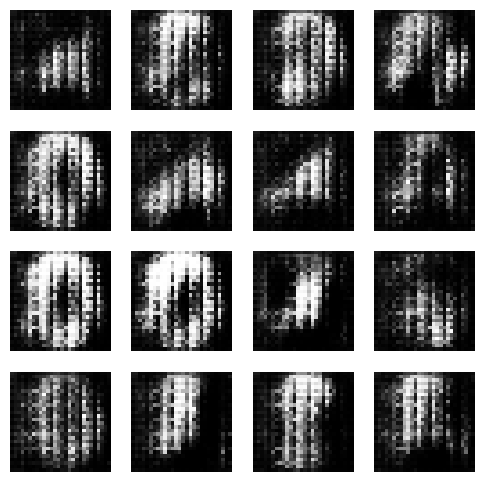

Epoch:  10


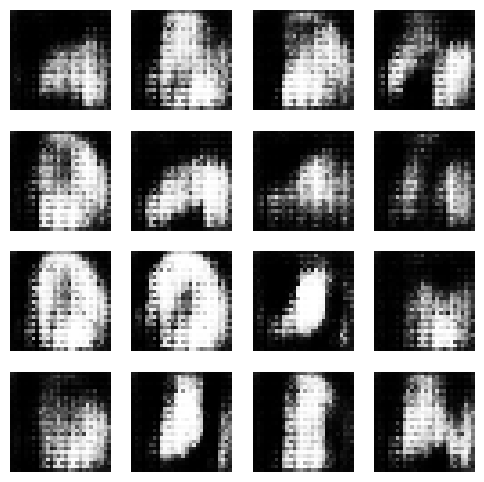

Epoch:  11


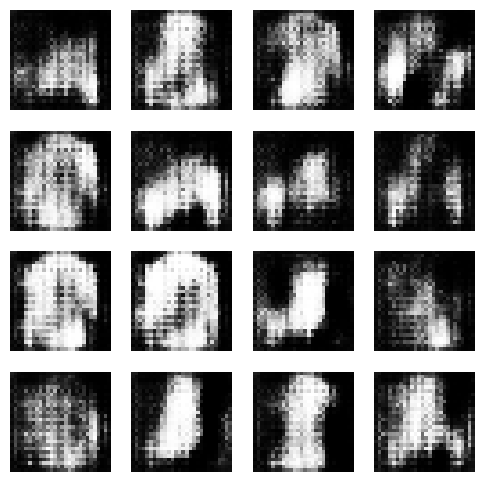

Epoch:  12


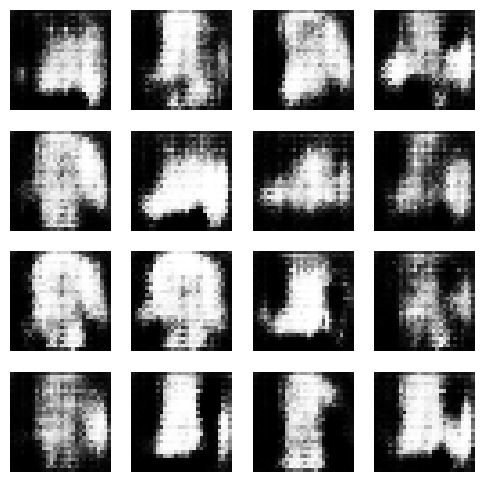

Epoch:  13


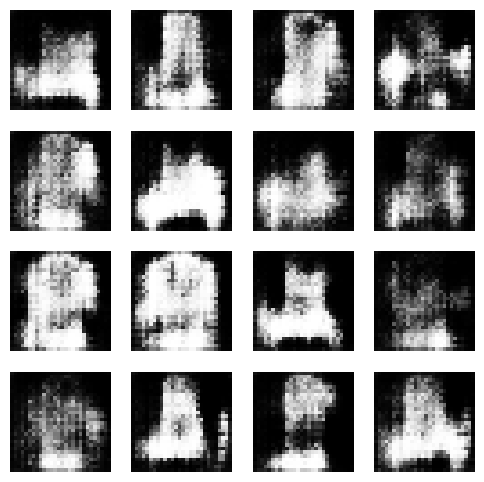

Epoch:  14


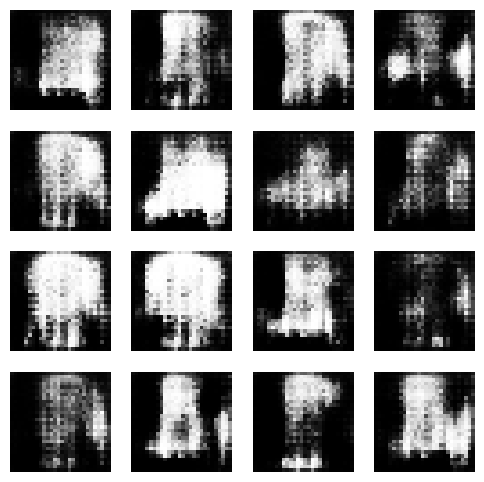

Epoch:  15


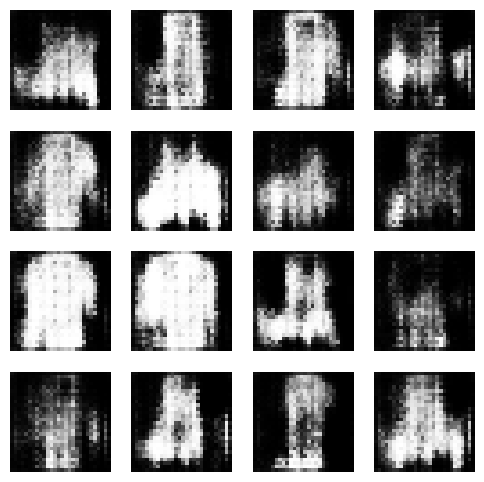

Epoch:  16


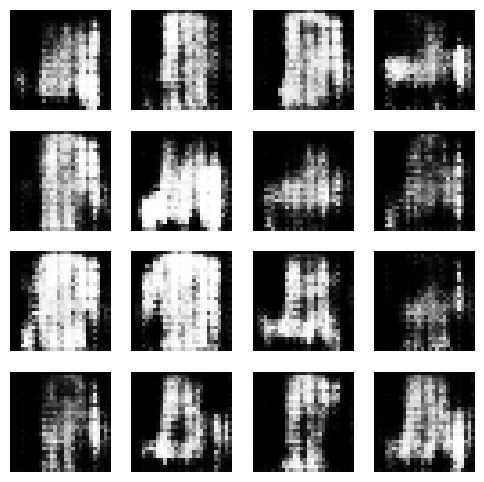

Epoch:  17


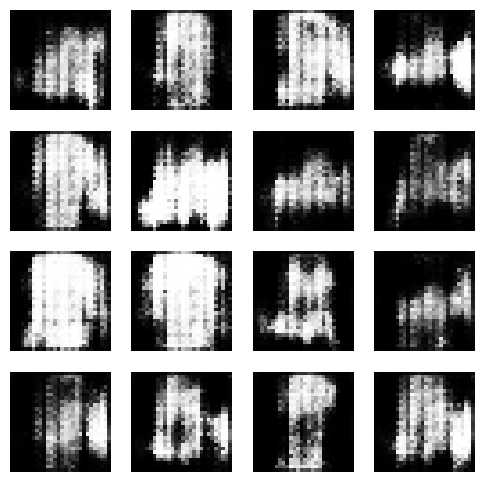

Epoch:  18


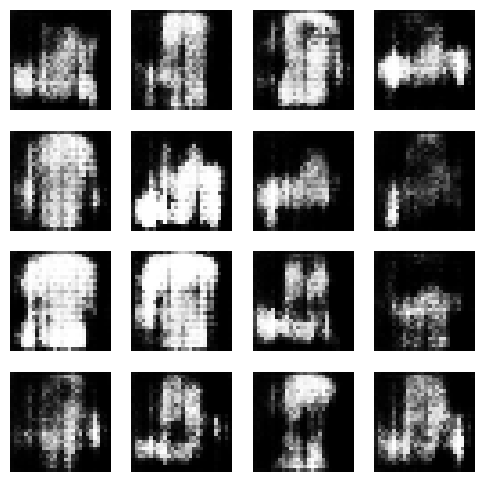

Epoch:  19


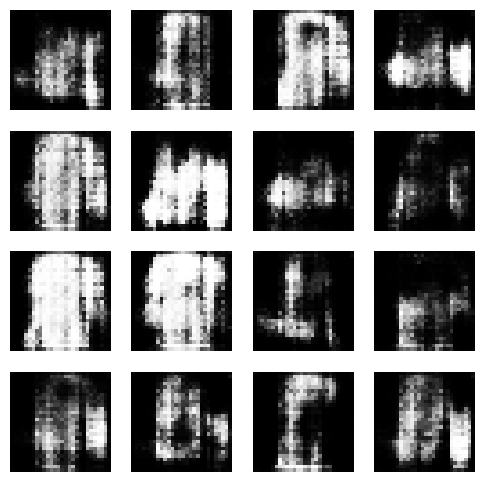

Epoch:  20


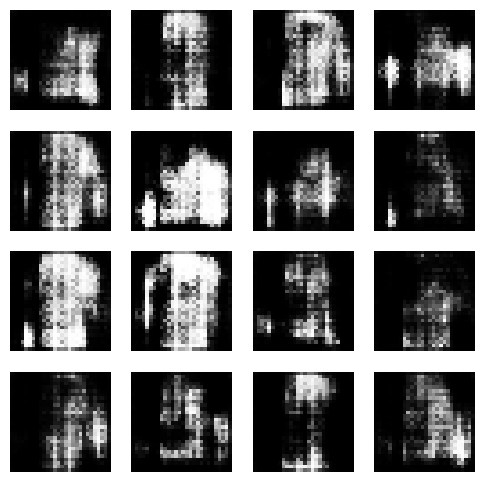

Epoch:  21


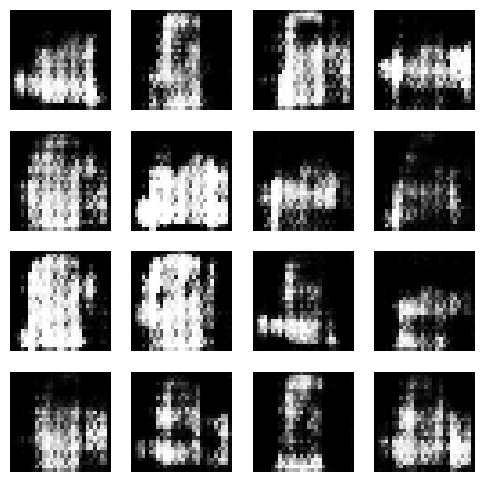

Epoch:  22


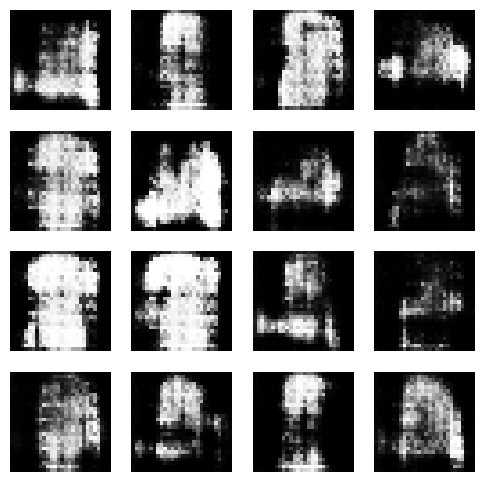

Epoch:  23


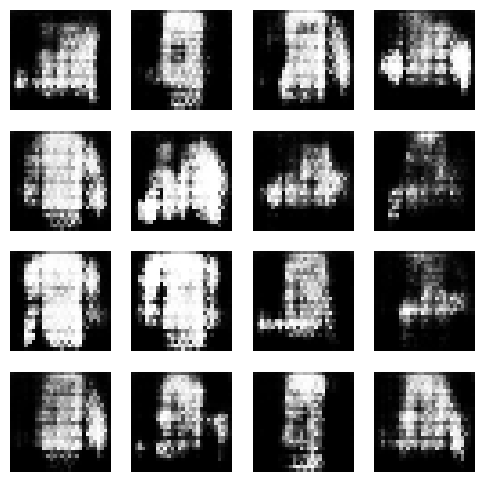

Epoch:  24


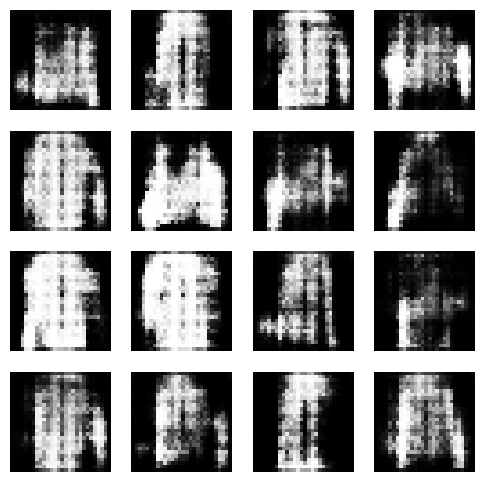

Epoch:  25


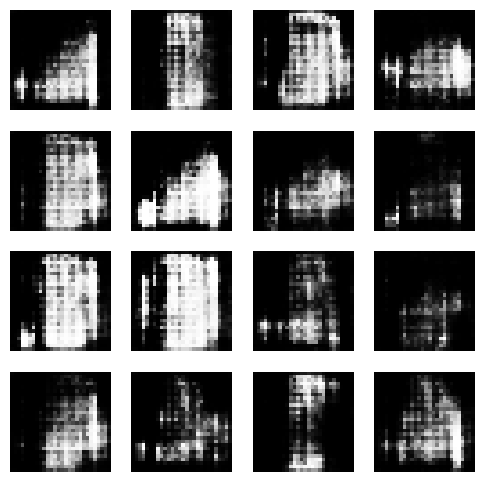

Epoch:  26


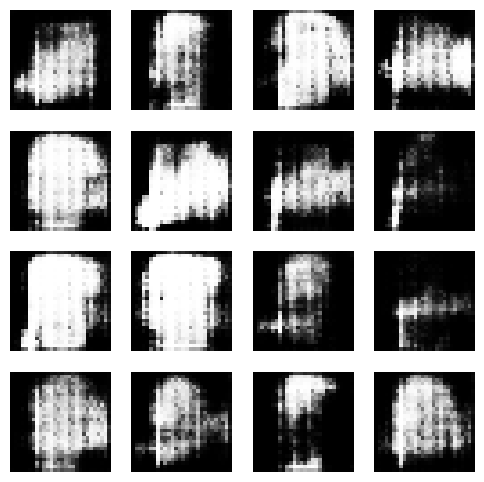

Epoch:  27


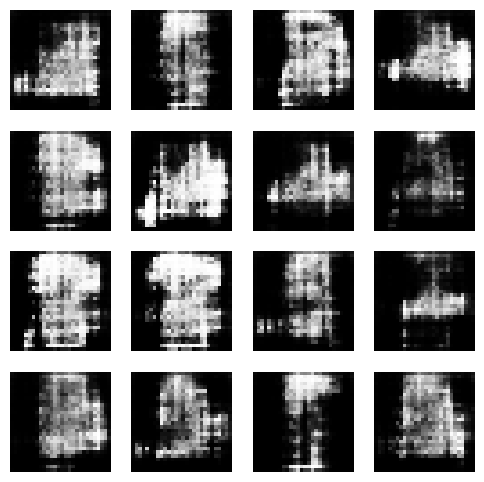

Epoch:  28


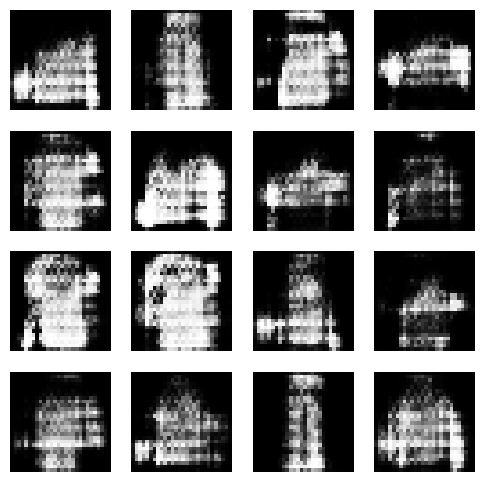

Epoch:  29


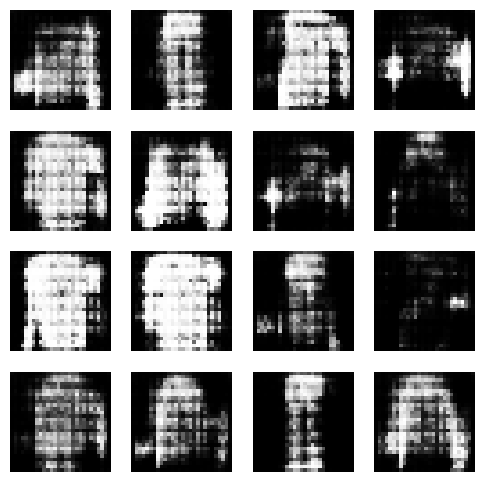

Epoch:  30


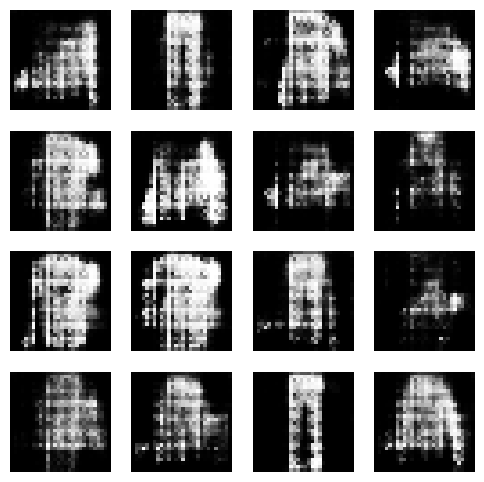

Epoch:  31


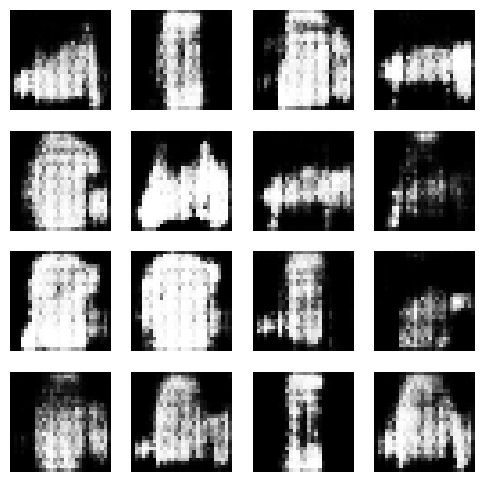

Epoch:  32


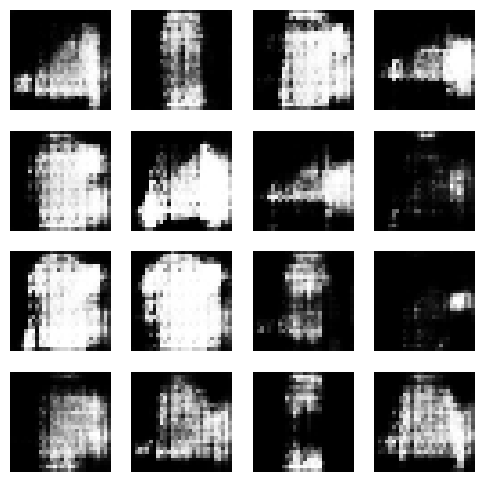

Epoch:  33


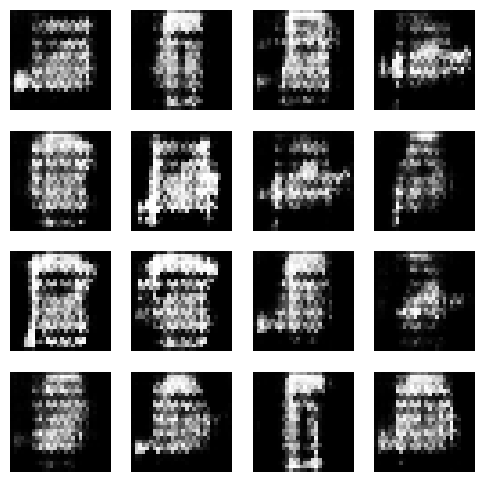

Epoch:  34


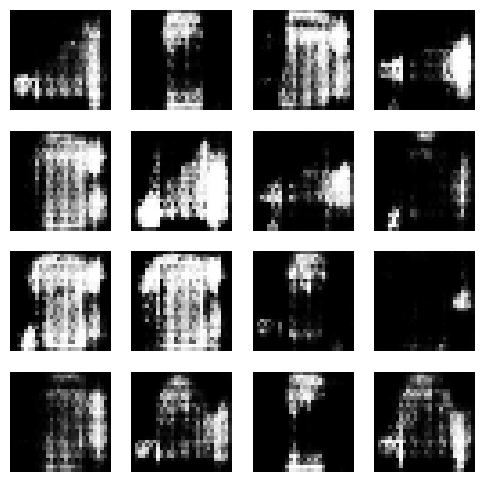

Epoch:  35


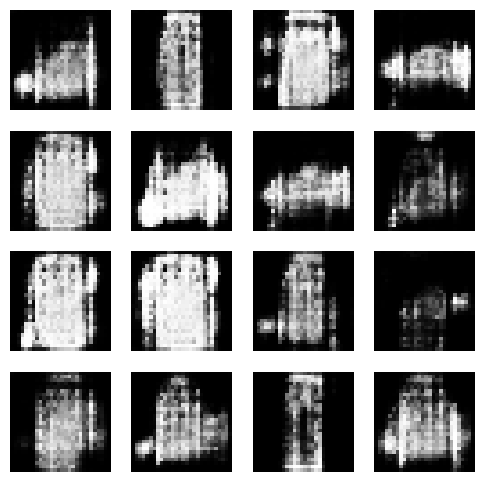

Epoch:  36


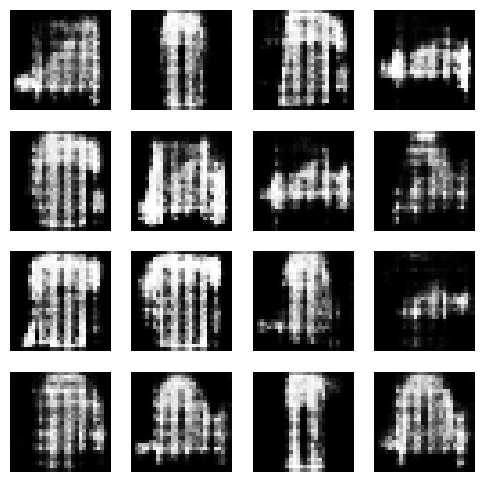

Epoch:  37


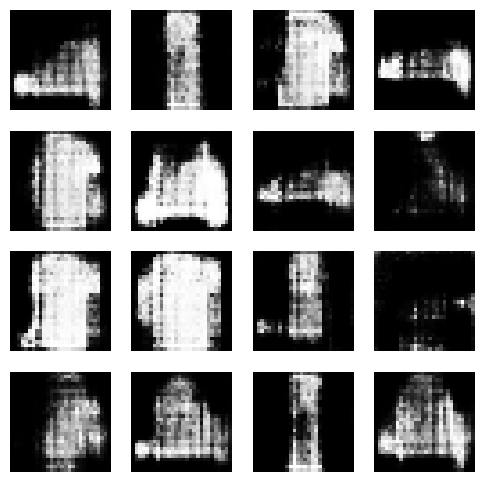

Epoch:  38


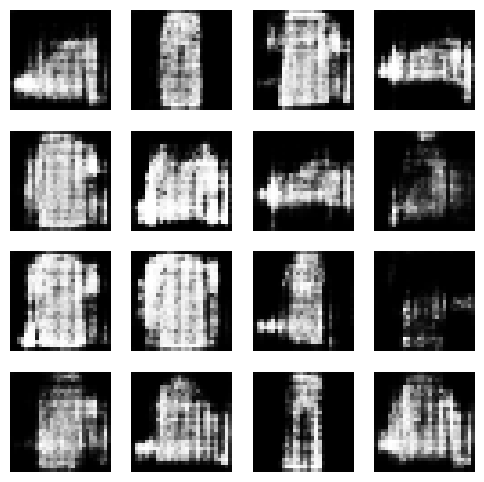

Epoch:  39


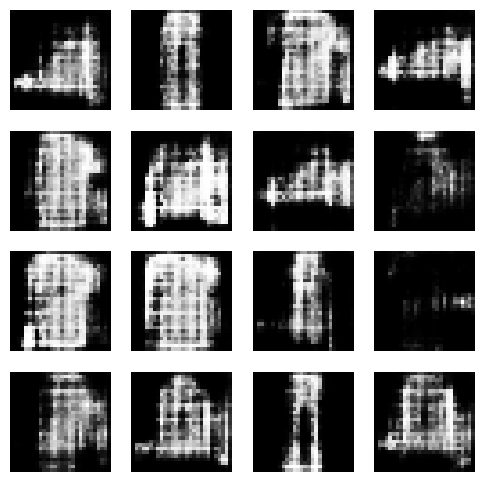

Epoch:  40


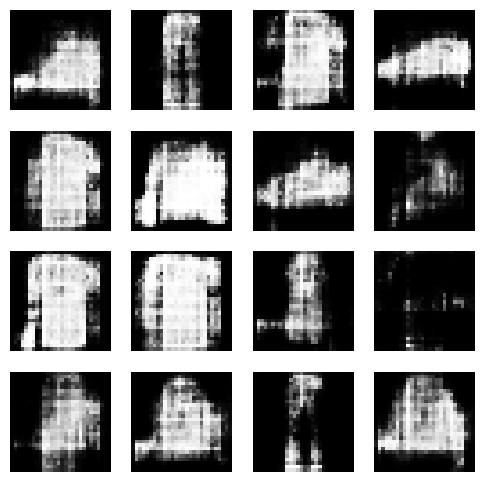

Epoch:  41


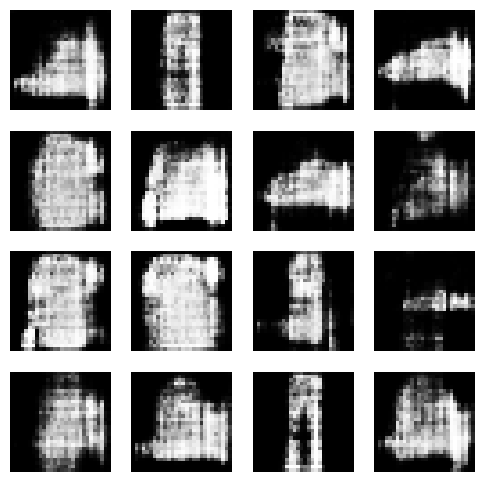

Epoch:  42


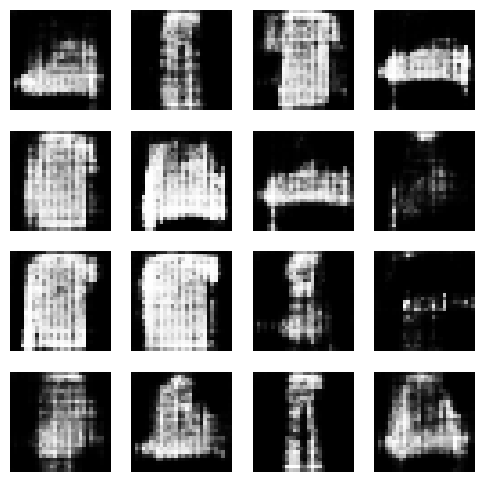

Epoch:  43


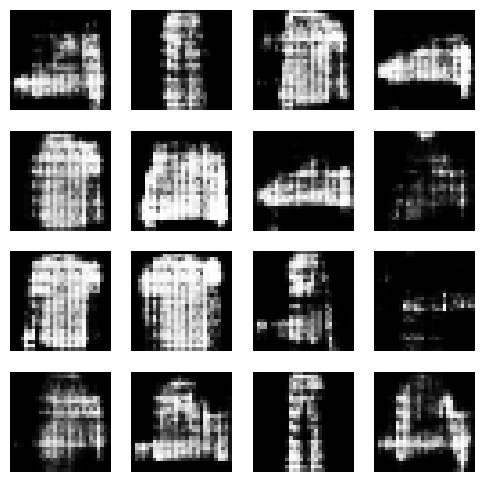

Epoch:  44


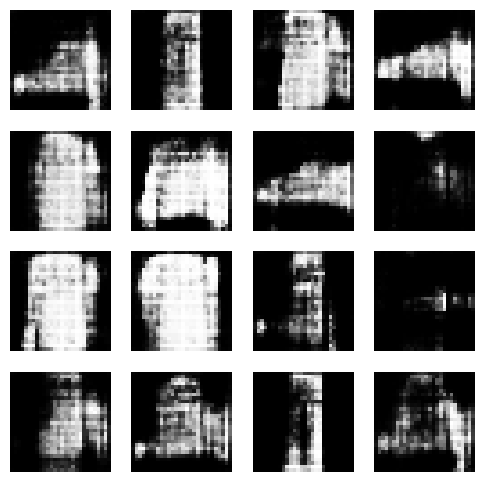

Epoch:  45


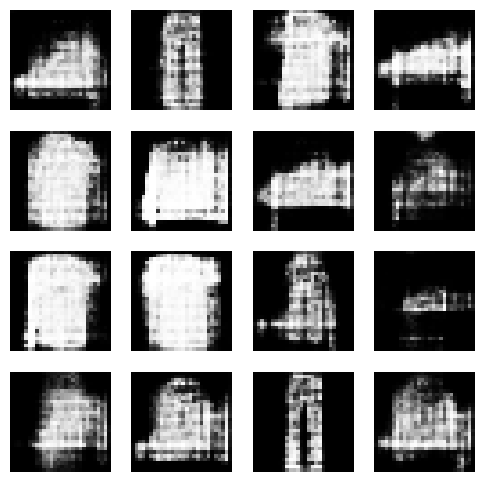

Epoch:  46


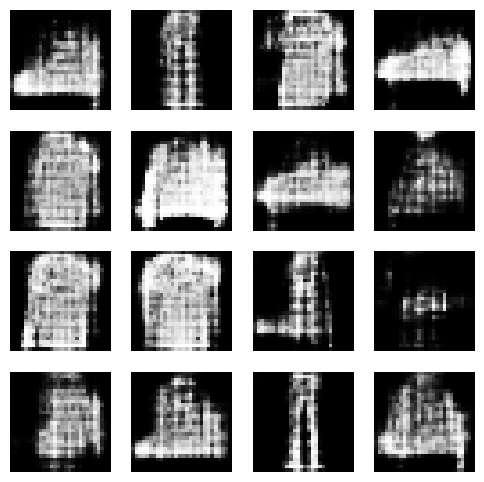

Epoch:  47


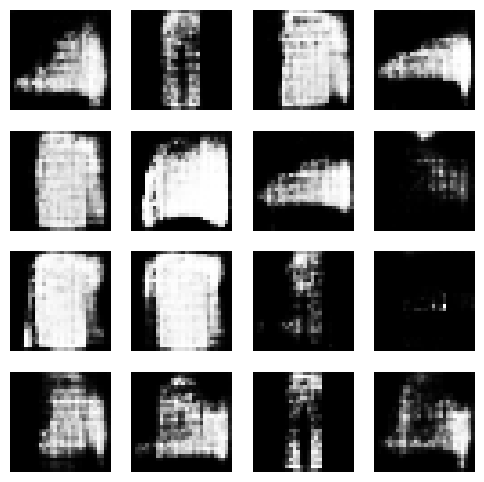

Epoch:  48


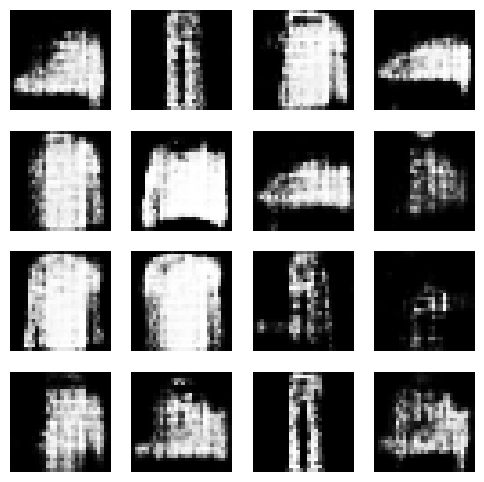

Epoch:  49


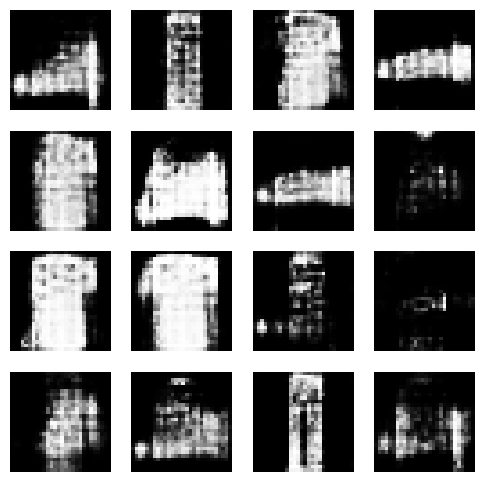

Epoch:  50


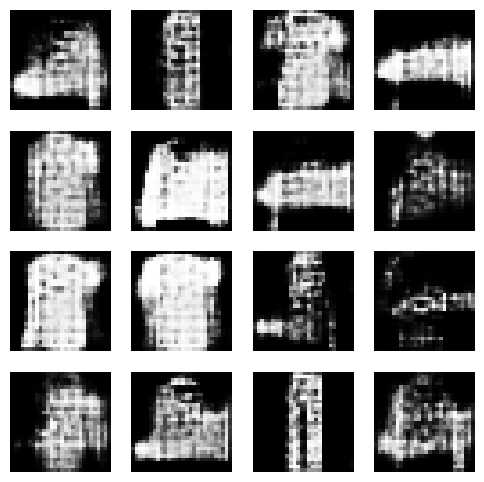

Epoch:  51


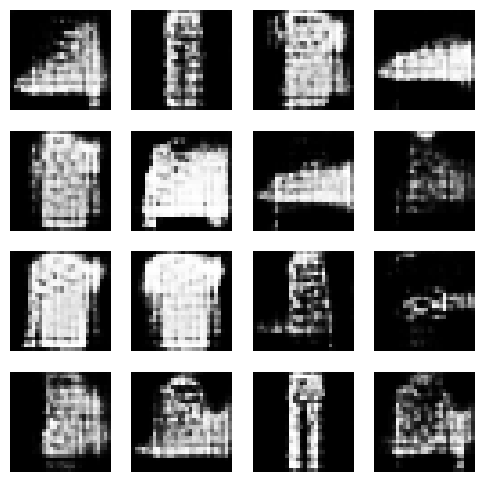

Epoch:  52


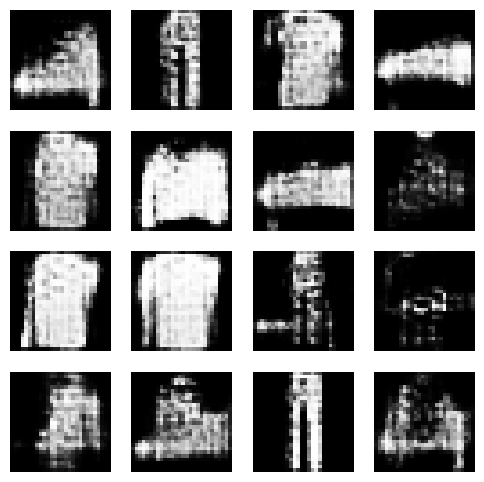

Epoch:  53


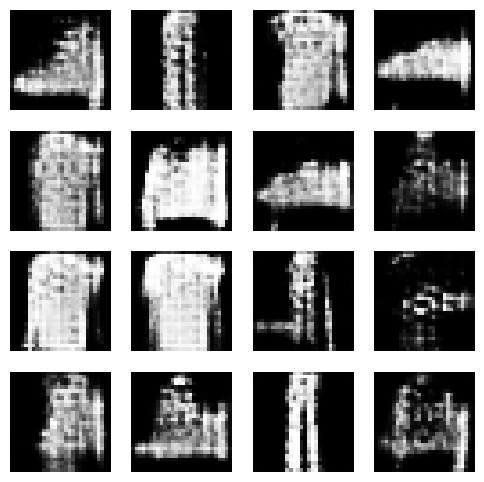

Epoch:  54


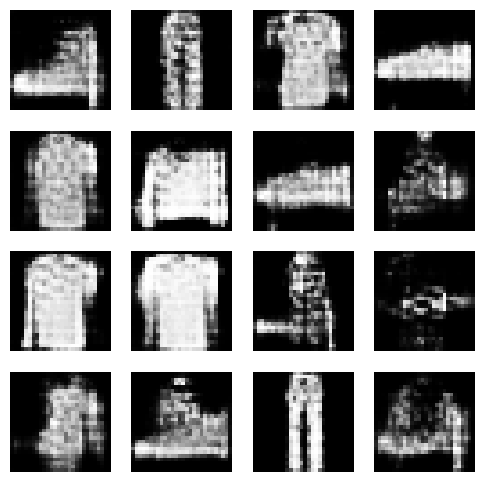

Epoch:  55


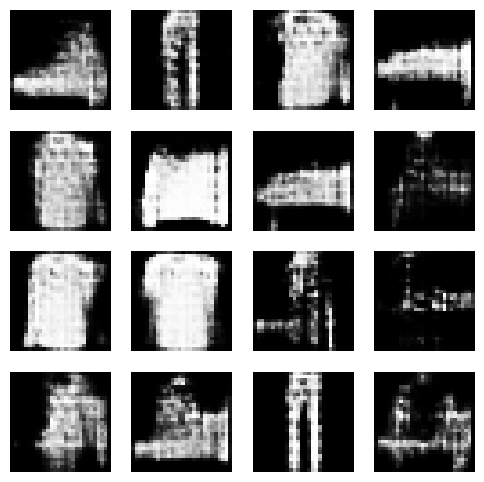

Epoch:  56


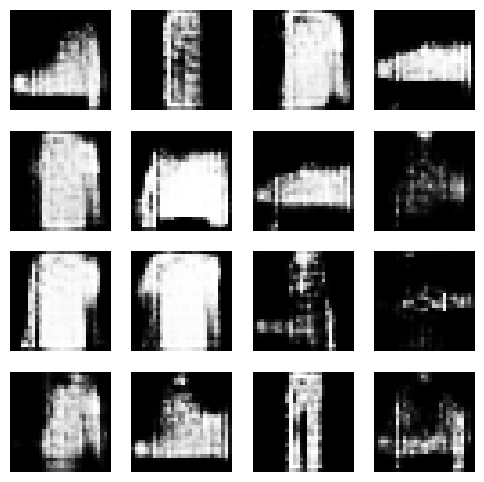

Epoch:  57


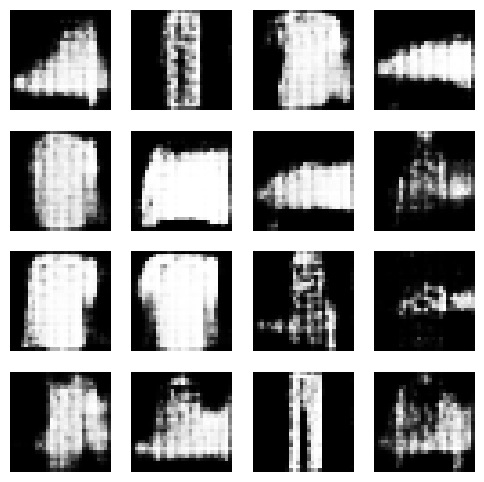

Epoch:  58


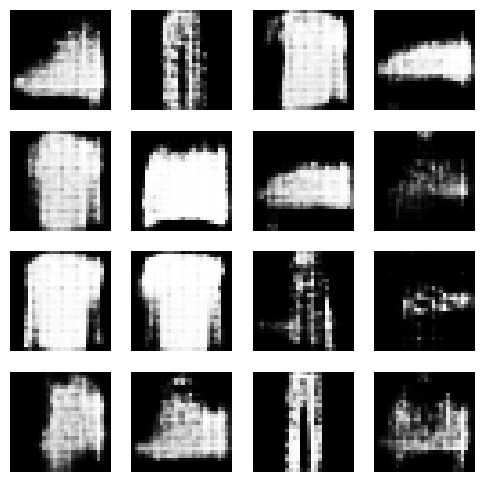

Epoch:  59


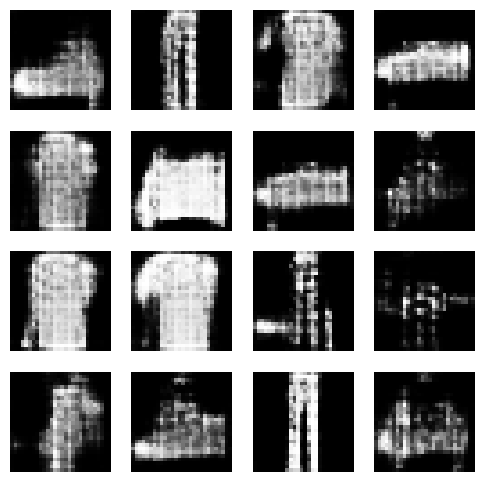

Epoch:  60


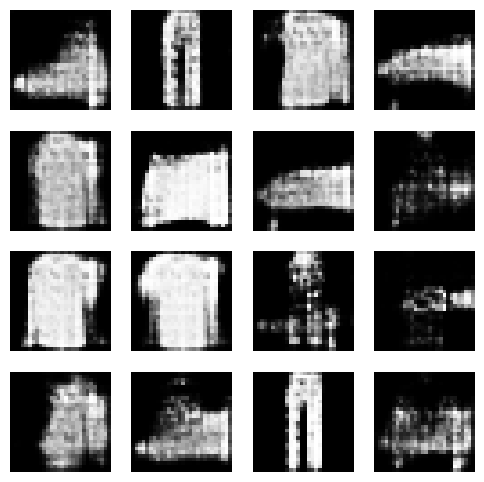

Epoch:  61


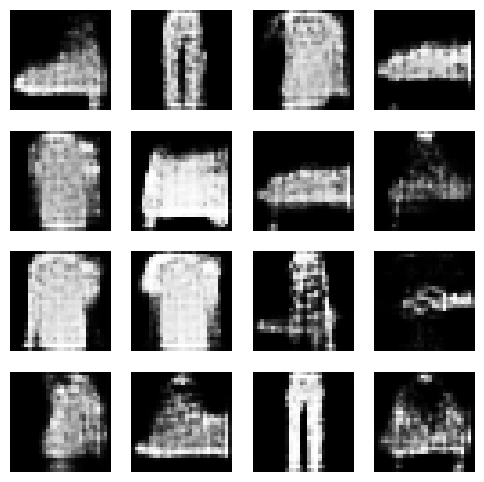

Epoch:  62


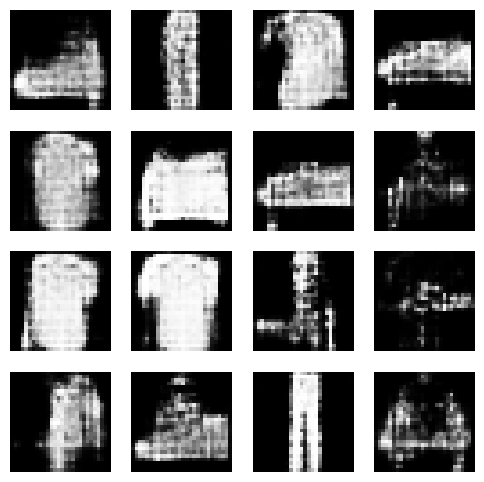

Epoch:  63


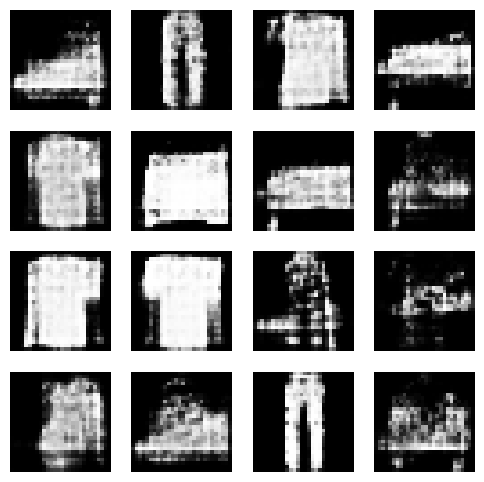

Epoch:  64


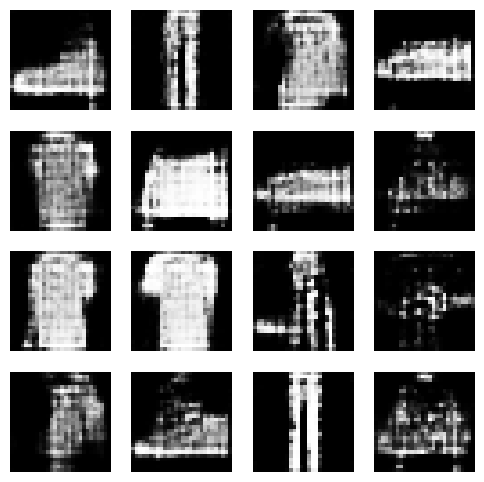

Epoch:  65


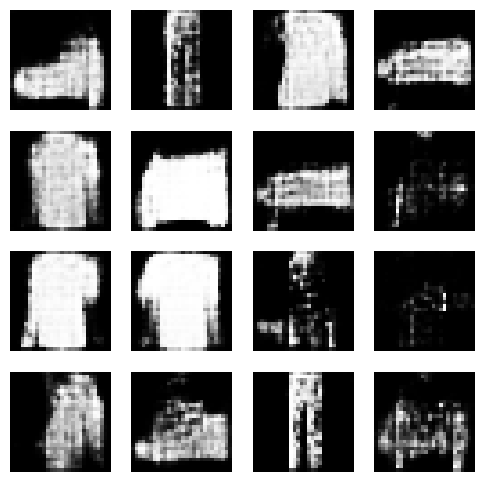

Epoch:  66


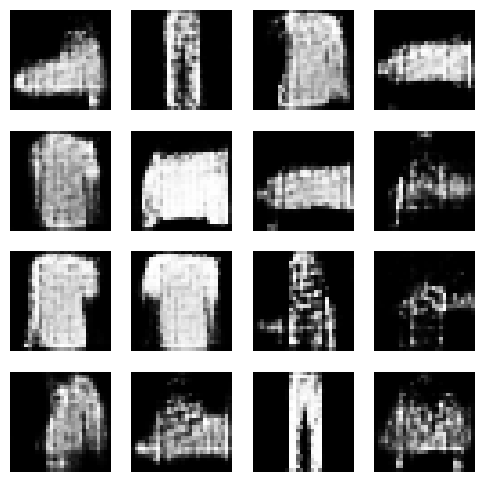

Epoch:  67


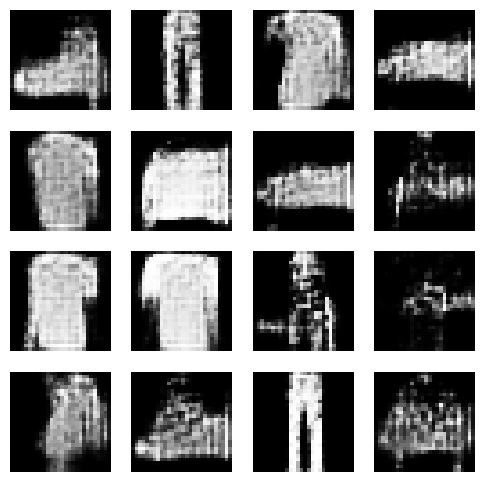

Epoch:  68


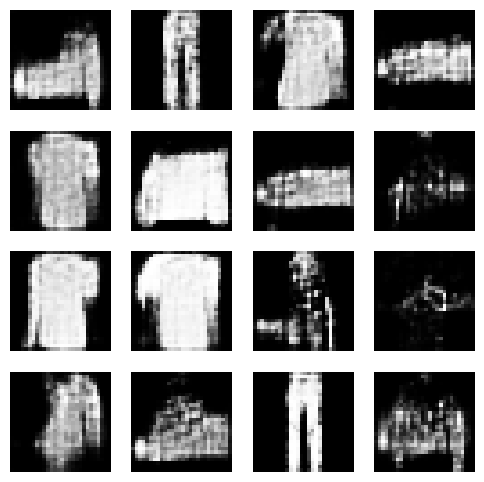

Epoch:  69


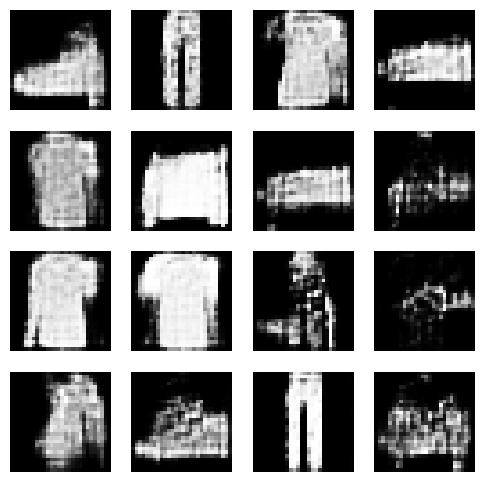

Epoch:  70


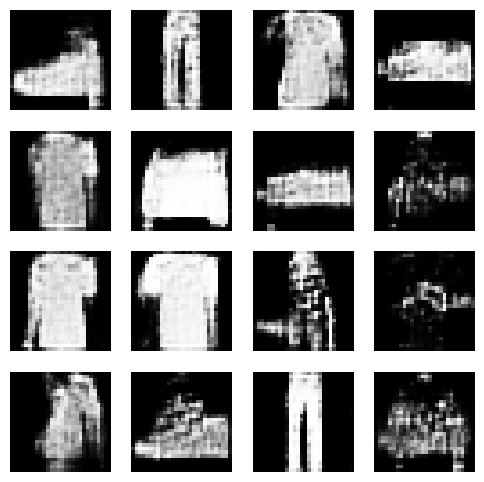

Epoch:  71


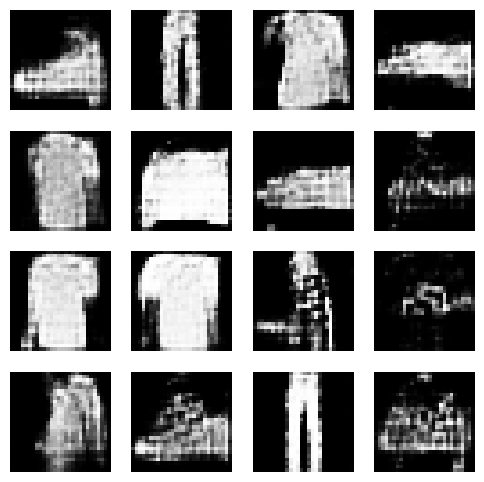

Epoch:  72


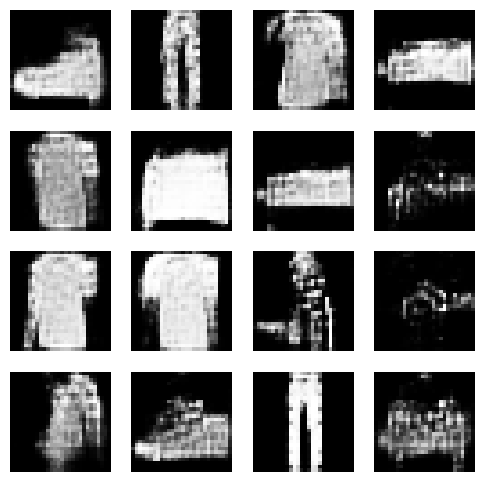

Epoch:  73


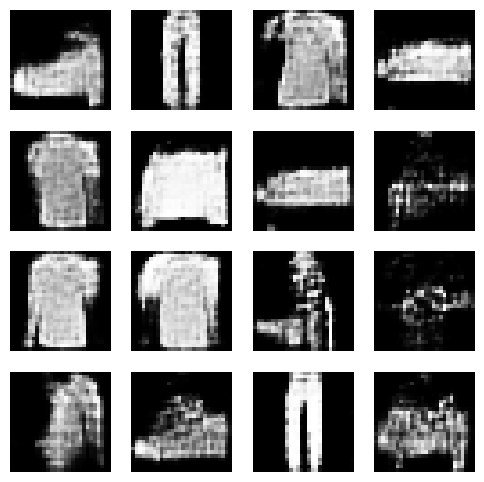

Epoch:  74


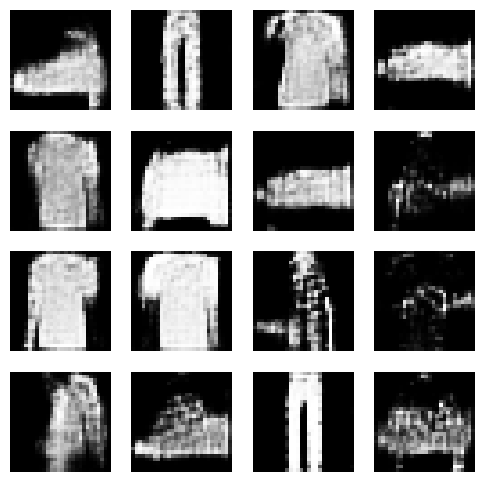

Epoch:  75


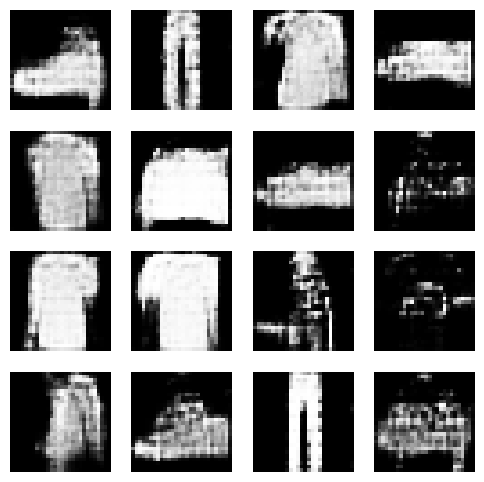

Epoch:  76


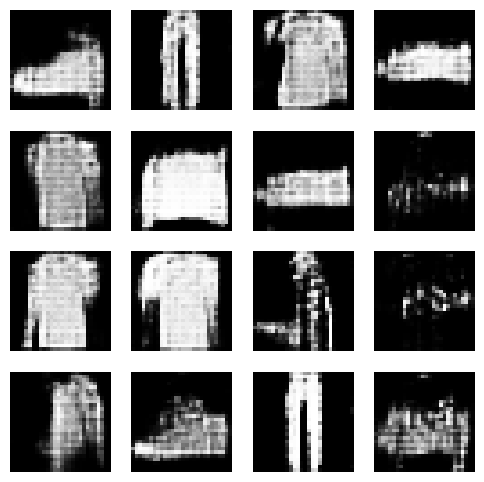

Epoch:  77


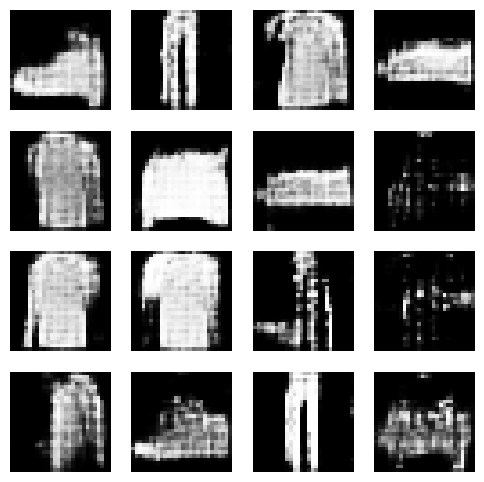

Epoch:  78


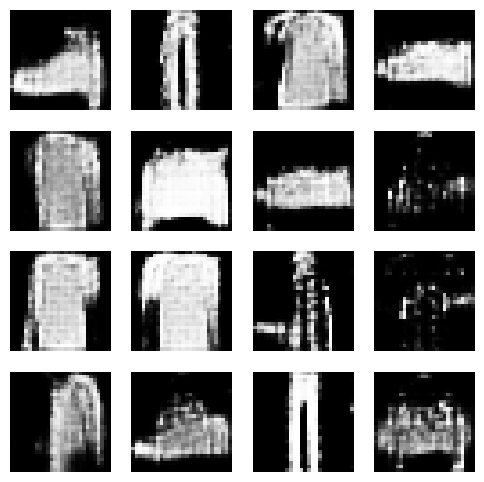

Epoch:  79


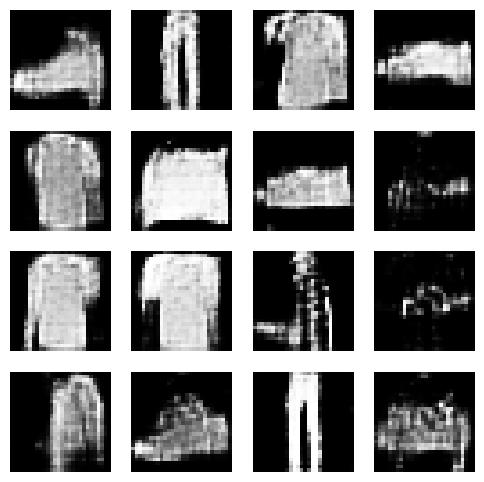

Epoch:  80


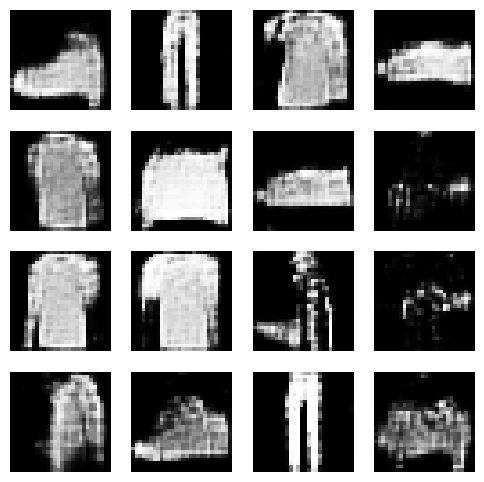

Epoch:  81


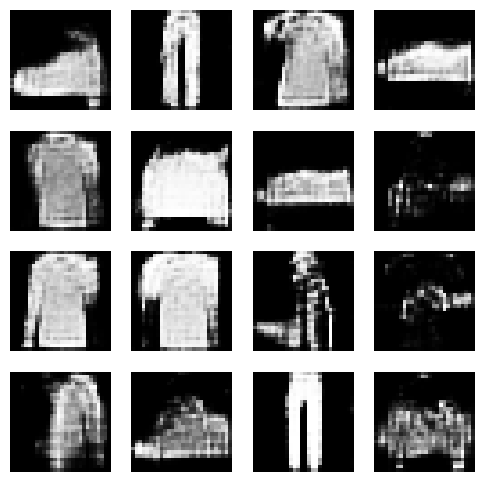

Epoch:  82


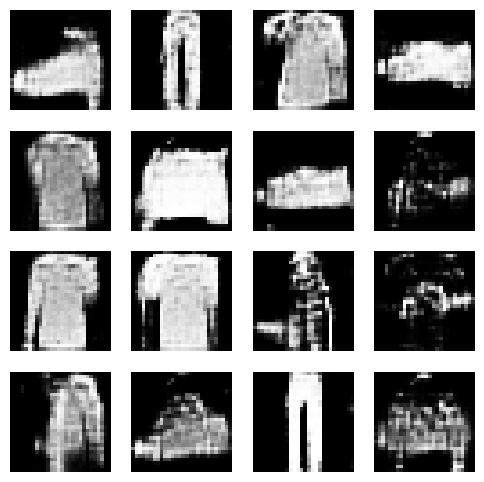

Epoch:  83


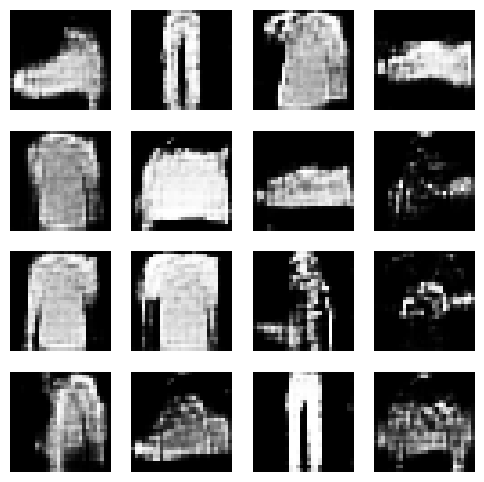

Epoch:  84


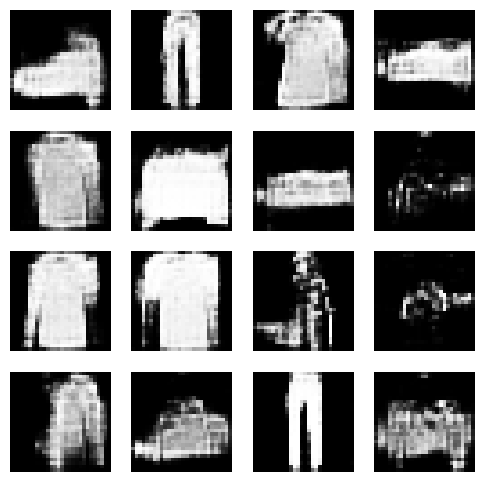

Epoch:  85


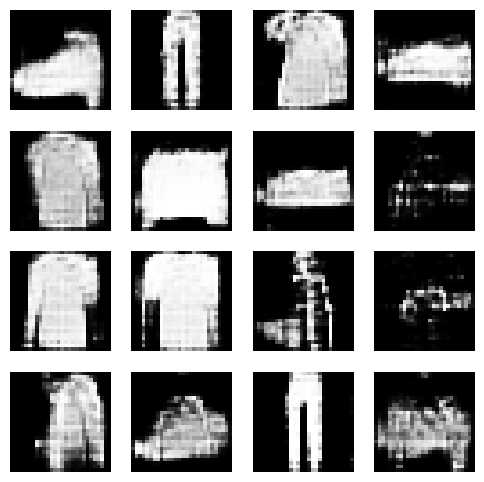

Epoch:  86


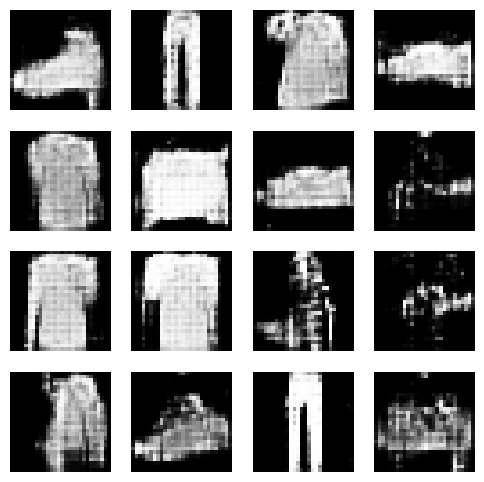

Epoch:  87


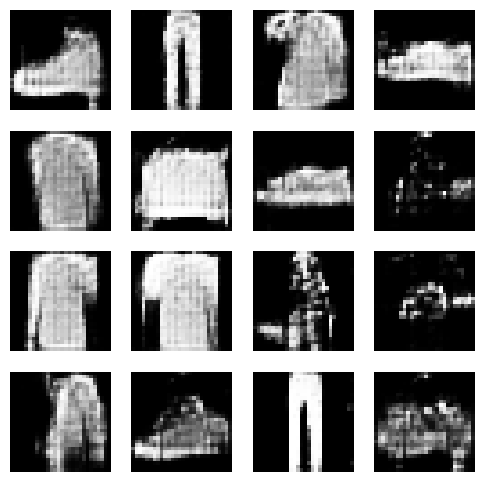

Epoch:  88


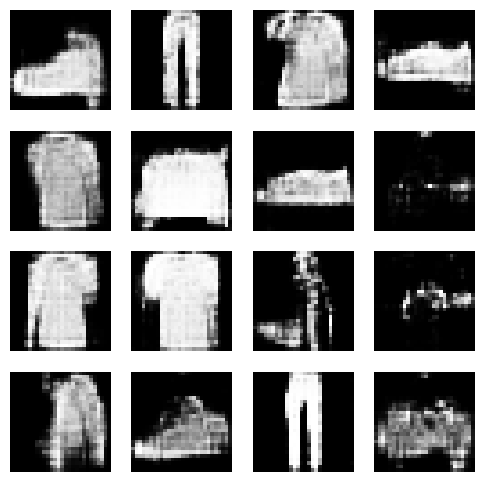

Epoch:  89


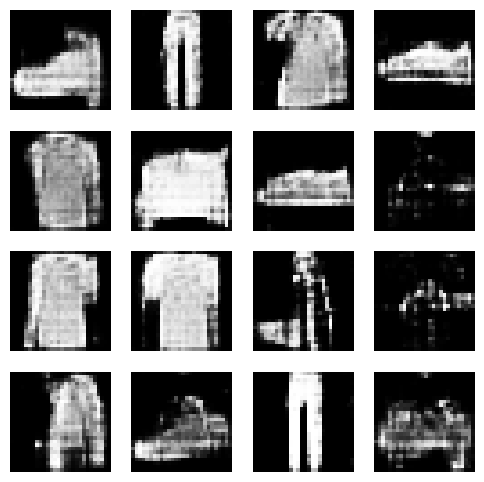

Epoch:  90


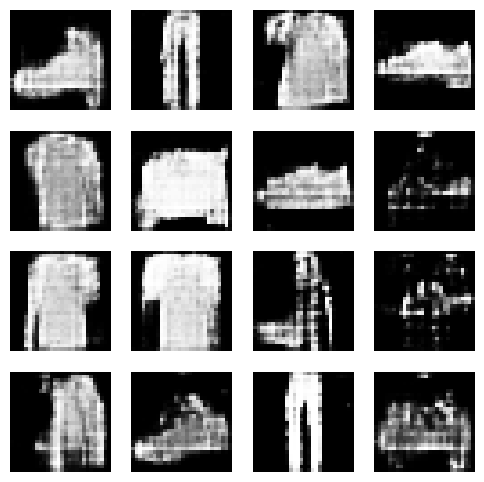

Epoch:  91


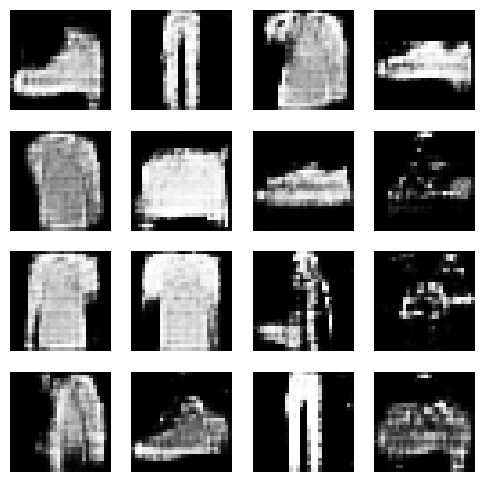

Epoch:  92


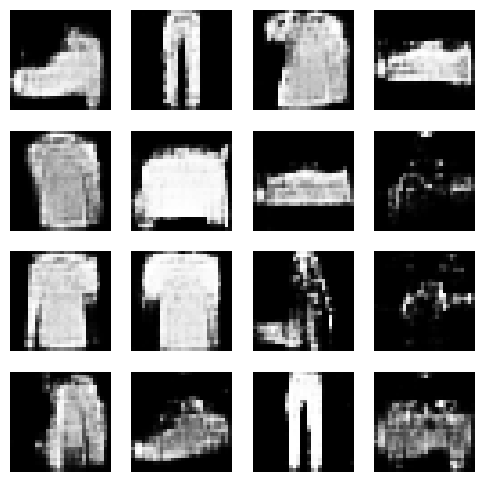

Epoch:  93


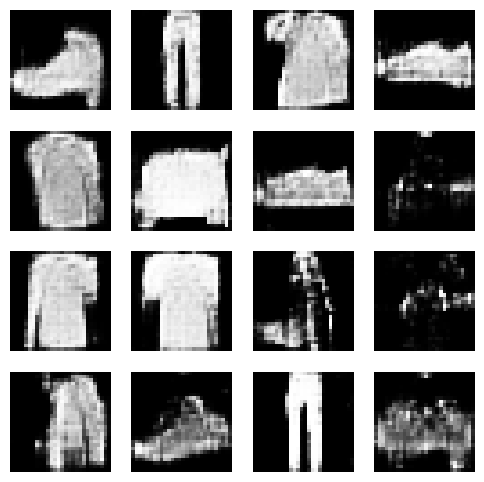

Epoch:  94


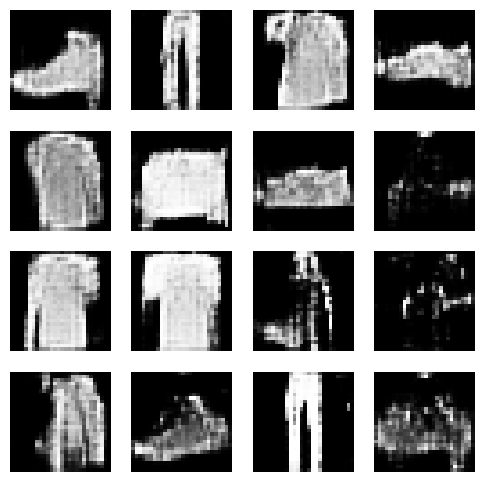

Epoch:  95


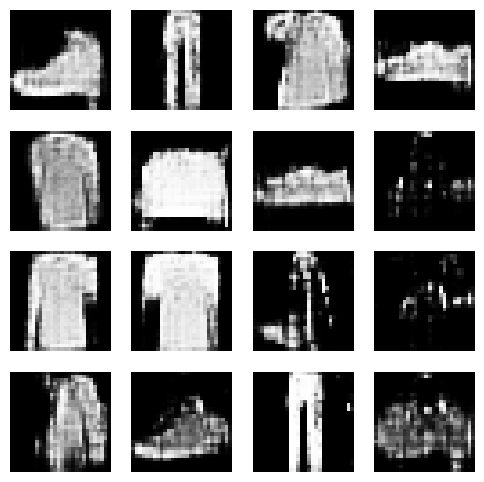

Epoch:  96


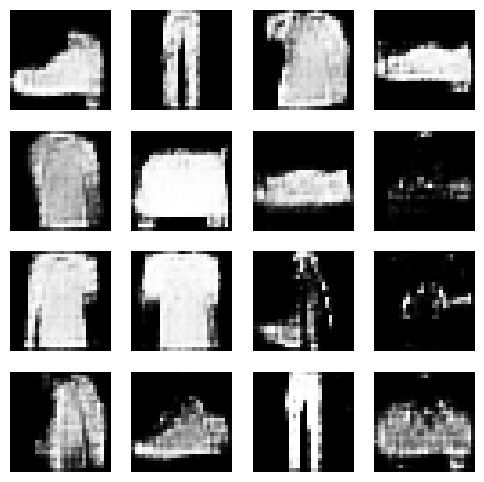

Epoch:  97


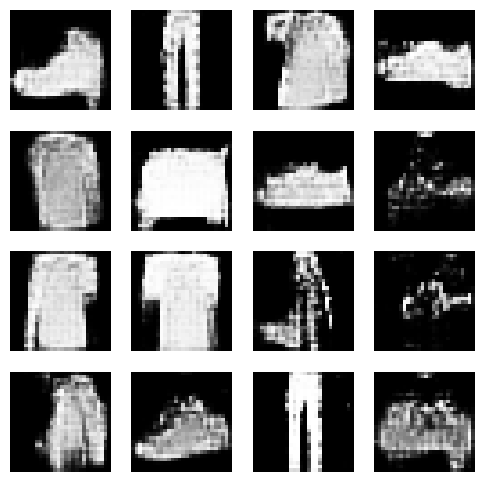

Epoch:  98


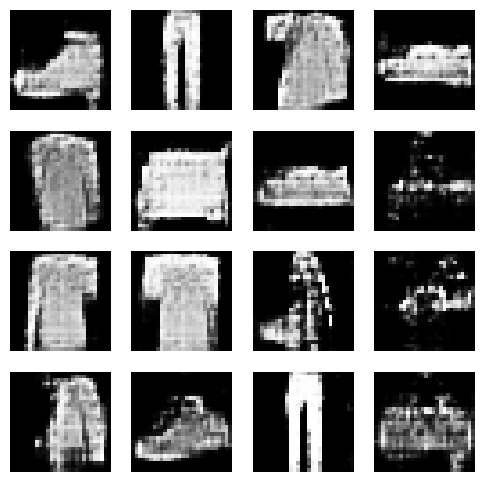

Epoch:  99


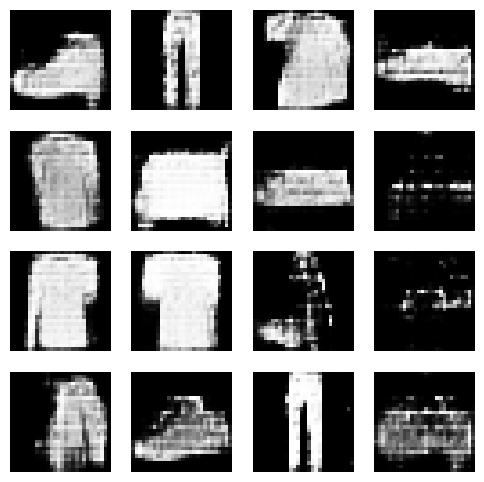

Epoch:  100


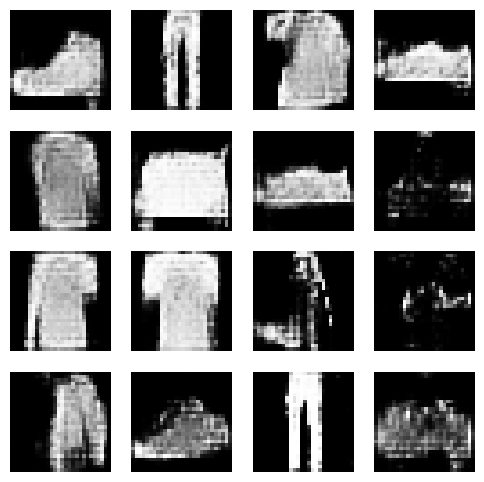

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = (X_train - 127.5) / 127.5
buffer_size = 60000
batch_size = 256
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size=(5,5), padding='same',use_bias=False, strides=(2,2), activation = 'tanh'))

  network.summary()

  return network

generator = build_generator()
generator.input

noise = tf.random.normal([1, 100])
noise

generated_image = generator(noise, training = False)

generated_image.shape

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network


discriminator = build_discriminator()
discriminator.input
discriminator(generated_image, training = False) # logits

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)



epochs = 100
noise_dim = 100
num_images_to_generate = 16

@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


test_images = tf.random.normal([num_images_to_generate, noise_dim])
test_images.shape

def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      #print(image_batch.shape)
      train_steps(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training=False)
    fig = plt.figure(figsize = (6,6))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

train(X_train, epochs, test_images)